
# Chapter 6

# Lab: Linear Models and Regularization Methods

Plain linear models are not always the best choice, or the one with the least test error, or the one that is easiest to interpret.

- Too few samples and too many parameters (n~p or n<p) implies high variance or maybe a least squares error impossible to attain as there would be no unique least squares coefficients.
- We may also have irrelevant parameters and we may want to remove them and thus simplify the model.

So we sometimes aim towards **feature selection** mechanisms.
- **Subset selection**: identifying a subset of the predictors that we believe to be related to the response. --> **preselection**.
    
    - **Best subset selection**:  Compute a separate least squares regression for each possible combination of `p` predictors. Then we pick the best one. Requires calculating $2^p$ models! -> impossible.
        - How to pick the best model? $R^2$ depends on the amount of predictors, so we must use $C_p$, AIC (Akaike information criterion), BIC (Bayesian information criterion), Adj $R^2$ (if linear regression) or using _deviance_ if logistic regression.
        - How to use cross-validation here?
            - When we are testing $k$ predictors, we must fit all $(p,k)$ models (all possible combinations of $k$ predictors from a group of $p$ possible ones),
            - and on each of those fits, we must apply K-fold.
                - That means that for each one of those possible models, we must go through all possible the possible folds (of samples)for that very case.
                - The validation errors are then averaged to select the best value of $k$.
    - **Stepwise selection**
        - **Forward stepwise selection**: Start with a model containing no predictors, and then adds one predictor at a time.
            - Which predictor to add? The one which generates the highest increase in model performance (however measured). 
        - **Backward stepwise selection**: Start with a model containing all the predictors, and the delete one predictor at a time.
            - Which predictor to add? The one which generates the highest increase in model performance (however measured). 
- **Shinkage**: Fitting with all predictors, and **shink the coefficients towards 0** to reduce the variance --> **Regularization**.
- **Dimension reduction**: Projecting the `p` predictors into an M-dimensional subspace, `M<p` --> Computes **linear combinations** of the predictors.

Indirect measurements of accuracy:
$$
C_p = \frac{1}{n} (RSS + 2d\hat{\sigma}^2) \approx MSE=\frac{RSS}{n}+\text{penalty},\qquad d:\text{\#predictors},\qquad \sigma: \text{estimate of variance}
$$

$$
BIC = \frac{1}{n} (RSS+\log(n) d \hat{\sigma}^2) \therefore \text{higher penalty on the number of variables}
$$

$$
Adj R^2 = 1 - \frac{RSS/(n-d-1)}{RSS/(n-1)} \therefore \text{Expected high!}
$$

Cross-validation to assess the accuracy, without using assumptions on the underlying model, and without knowing the degrees of freedom of the model.


In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial


We again collect the new imports
needed for this lab.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path


We have installed the package `l0bnb` on the fly. Note the escaped `!pip install` --- this is run as a separate system command. 
## Subset Selection Methods
Here we implement methods that reduce the number of parameters in a
model by restricting the model to a subset of the input variables.

### Forward Selection
 
We will  apply the forward-selection approach to the  `Hitters` 
data.  We wish to predict a baseball player’s `Salary` on the
basis of various statistics associated with performance in the
previous year.

First of all, we note that the `Salary` variable is missing for
some of the players.  The `np.isnan()`  function can be used to
identify the missing observations. It returns an array
of the same shape as the input vector, with a `True` for any elements that
are missing, and a `False` for non-missing elements.  The
`sum()`  method can then be used to count all of the
missing elements.

In [3]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()


59

 We see that `Salary` is missing for 59 players. The
`dropna()`  method of data frames removes all of the rows that have missing
values in any variable (by default --- see  `Hitters.dropna?`).

In [4]:
Hitters = Hitters.dropna();
Hitters.shape


(263, 20)

We first choose the best model using forward selection based on $C_p$ (6.2). This score
is not built in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use
it as a scorer. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.

In [5]:
def nCp(sigma2, # this value should be calculated beforehand
        estimator, # it needs a predict method
        X, # predictors
        Y): # results to compare predictions with
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2) # Compare predictions with actual values
    return -(RSS + 2 * p * sigma2) / n 


We need to estimate the residual variance $\sigma^2$, which is the first argument in our scoring function above.
We will fit the biggest model, using all the variables, and estimate $\sigma^2$ based on its MSE.

In [6]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters) # So on the model we use all possible predictors except for the salary
Y = np.array(Hitters['Salary']) # And here we define the column that is the result
X = design.transform(Hitters) # The predictors are transformed (by MS, of course)
model = OLS(Y,X).fit() # and here we fit them!
sigma2 = model.scale # The variance is obtained from the OLS method.
sigma2

99591.35617968219

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     15.39
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           7.84e-32
Time:                        23:55:27   Log-Likelihood:                -1876.2
No. Observations:                 263   AIC:                             3792.
Df Residuals:                     243   BIC:                             3864.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      163.1036     90.779      1.797      0.074     -15.710     341.917
AtBat           -1.9799      0.634     -3.123      0.002      -3.229      -0.731
Hits             7.5008      2.378      3.155      0.002       2.818      12.184
HmRun            4.3309      6.201      0.698      0.486      -7.885      16.546
Runs            -2.3762      2.981     -0.797      0.426      -8.248       3.495
RBI             -1.0450      2.601     -0.402      0.688      -6.168       4.078
Walks            6.2313      1.829      3.408      0.001       2.630       9.833
Years           -3.4891     12.412     -0.281      0.779     -27.938      20.960
CAtBat          -0.1713      0.135     -1.267      0.206      -0.438       0.095
CHits            0.1340      0.675      0.199      0.843      -1.195       1.463
CHmRun          -0.1729      1.617     -0.107      0.915      -3.358       3.013
CRuns            1.4543      0.750      1.938      0.054      -0.024       2.933
CRBI             0.8077      0.693      1.166      0.245      -0.557       2.172
CWalks          -0.8116      0.328     -2.474      0.014      -1.458      -0.165
League[N]       62.5994     79.261      0.790      0.430     -93.528     218.727
Division[W]   -116.8492     40.367     -2.895      0.004    -196.363     -37.335
PutOuts          0.2819      0.077      3.640      0.000       0.129       0.434
Assists          0.3711      0.221      1.678      0.095      -0.065       0.807
Errors          -3.3608      4.392     -0.765      0.445     -12.011       5.290
NewLeague[N]   -24.7623     79.003     -0.313      0.754    -180.380     130.855
==============================================================================
Omnibus:                       87.414   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              452.923
Skew:                           1.236   Prob(JB):                     4.46e-99
Kurtosis:                       8.934   Cond. No.                     2.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The function `sklearn_selected()` expects a scorer with just three arguments --- the last three in the definition of `nCp()` above. We use the function `partial()` first seen in Section 5.3.3 to freeze the first argument with our estimate of $\sigma^2$.

In [8]:
neg_Cp = partial(nCp, sigma2) # nCp requires 4 argumnets, so we fix one of them.


We can now use `neg_Cp()` as a scorer for model selection.


Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.

In [10]:
strategy = Stepwise.first_peak(design, # look for the first peak!
                               direction='forward', # perform forward selection
                               max_terms=len(design.terms)) # there is a limit to the amount of parameters we can use if we didn't find a peak
# this defines just the strategy
strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x738ee0df6c90>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=<function first_peak at 0x738e8a47a340>, postprocess=<function _postprocess_best at 0x738e8a47a5c0>)

We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be
selected.

In [14]:
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [15]:
hitters_MSE = sklearn_selected(OLS,       # OLS already knows the input and output values. It's already been fit!
                               strategy)  # The strategy is forward selection until first peak
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_


('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [16]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp) # We now change the scorer: now it makes much more sense.
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

Now it would be nice to use scikit learn directly.

In [60]:
X_sk

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,A


Forward selection

In [31]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression # Instead of OLS from statsmodels
from sklearn.datasets import make_regression

X_sk = Hitters[Hitters.columns.drop(['Salary', 'League', 'Division', 'NewLeague'])] # We drop everything that is not a number, and the results column.
Y_sk = np.array(Hitters['Salary'])

# Initialize the model
model = LinearRegression()

# Create forward selector
sfs_fwd = SequentialFeatureSelector(     # This is a transformer
                estimator=model,         # the linear regression: It was not been fit yet.
                n_features_to_select='auto',  # Can specify exact number
                direction='forward',     # forward selection!
                scoring=neg_Cp,          # Previously defined scoring function
                cv=None                  # None, but if we were to write 5, it would use 5-fold Cross validation!
)

# Fit the selector. Do not fit the model itself, but the selector. We've given the selector the model to fit.
sfs_fwd.fit(X_sk, Y_sk)

# Get results
print("Selected features:", sfs_fwd.get_support(indices=True))
print("Feature names:", [f"Feature {X_sk.columns[i]}" for i in sfs_fwd.get_support(indices=True)])

Selected features: [ 0  1  3  5  6 10 11 13]
Feature names: ['Feature AtBat', 'Feature Hits', 'Feature Runs', 'Feature Walks', 'Feature Years', 'Feature CRuns', 'Feature CRBI', 'Feature PutOuts']


In [32]:
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

Backward selection

In [33]:
X_sk = Hitters[Hitters.columns.drop(['Salary', 'League', 'Division', 'NewLeague'])] # We drop everything that is not a number, and the results column.
Y_sk = np.array(Hitters['Salary']) 

# Initialize the model
model = LinearRegression()

# Create forward selector
sfs_back = SequentialFeatureSelector(     # This is a transformer
                estimator=model,     # the linear regression
                n_features_to_select='auto',  # Can specify exact number
                direction='backward', # backward selection!
                scoring=neg_Cp,      # Previously defined scoring function
                cv=None                 # None, but if we were to write 5, it would use 5-fold Cross validation!
)

# Fit the selector
sfs_back.fit(X_sk, Y_sk)

# Get results
print("Selected features:", sfs_back.get_support(indices=True))
print("Feature names:", [f"Feature {X_sk.columns[i]}" for i in sfs_back.get_support(indices=True)])

Selected features: [ 0  1  5  7 10 11 12 13]
Feature names: ['Feature AtBat', 'Feature Hits', 'Feature Walks', 'Feature CAtBat', 'Feature CRuns', 'Feature CRBI', 'Feature CWalks', 'Feature PutOuts']


In [34]:
sfs_fwd.get_support(indices=True) == sfs_back.get_support(indices=True)

array([ True,  True, False, False, False, False, False,  True])

### Choosing Among Models Using the Validation Set Approach and Cross-Validation
 
As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` 
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

```
 |  |---------- each row corresponds to a given set of predictors -------------|   
 |  |--------- Predictor A, B and C in this row are to be evaluated -----------|
 S  |---------- Predictor C, D, and F are evaluated here ----------------------|
 e  |----- Which predictors are evaluated here depends on the select alg ------|
 l  |--------------------------------------------------------------------------| <--- call cross_val_predict() on each row
 P  |------|------|------|--------|----|------|------|-----|-------|------|----|
 A  |------|------|------|--------|----|------|------|-----|-------|------|----|
 T  |-- Each item in these rows is just an instance for the cross-validation   |
 H  |-- and so each item has the same predictors but with different test sets--|
 |  |------|------|------|--------|----|------|------|-----|-------|------|----|
 !  |------|------|------|--------|----|------|------|-----|-------|------|----|
```

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [38]:
strategy = Stepwise.fixed_steps(design,            # design was MS(Hitters.columns.drop('Salary')).fit(Hitters)
                                len(design.terms), # these are the columns or predicts to use
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)


What do we expect to happen here?
1. The predictor with the biggest impact on the RSS is selected, after having performed several tests with cross-validation on all the predictors.
    - So for predictor A, the model was fit ~5 times with different samples. This results on the RSS for that predictor.
    - Do the same for all predictors, and pick the one with the highest impact on the RSS.
2. Then move on to use more predictors, and on each case, the predictor with the highest impact is the one to be chosen. For for each predictor, again, a cross-validation has to be performed.

If we were not using cross_validation, it would work like this 
```python
list_of_selected_predictors = []
remaining_predictors = all_predictors
best_score = -infinity

while True:
    candidate_scores = []
    
    for predictor in remaining_predictors:
        # Try adding this feature
        current_features = list_of_selected_predictors + [predictor]
        
        # Single train-test split
        model.fit(X_train[current_features], y_train)
        score = model.score(X_test[current_features], y_test)
        candidate_scores.append(score)
    
    # Find best new feature
    best_new_score = max(candidate_scores)
    best_feature = remaining_predictors[argmax(candidate_scores)]
    
    if best_new_score <= best_score: 
        break  # Stop if no improvement
    
    # Update selections
    selected.append(best_feature)
    remaining.remove(best_feature)
    best_score = best_new_score
```

```mermaid
flowchart TD
    A[Start: Empty selected features] --> B[Initialize remaining = all features]
    B --> C{Any remaining features?}
    C -->|Yes| D[Try adding each remaining feature]
    D --> E[Train model with current + new feature]
    E --> F[Score model on test set]
    F --> G[Track all feature scores]
    G --> H[Select feature with best score]
    H --> I{Better than previous best?}
    I -->|Yes| J[Add to selected features\nRemove from remaining\nUpdate best score]
    J --> C
    I -->|No| K[End: Return selected features]
    C -->|No| K
```

If we use CV:
```python
list_of_selected_predictors = []
remaining_predictors = all_predictors
while previous_calculated_score_is_not_max:
    score_for_new_predictors = []
    for each_predictor in remaining_predictors:
        list_of_predictors_to_test = [list_of_selected_predictors, each_predictor]

        # Cross validation
        folds = divide_samples_into_k_groups(k=5)
        scores = []
        for validation_fold in folds:
            train_fold = folds.remove(validation_fold)
            model.fit(list_of_predictors_to_test, train_fold)
            score = model.predict(validation_fold).score()
        # Score for new predictor is cross-validated
        score_for_new_predictors = scores.mean()

    if score_for_new_predictos[last]<score_for_new_predictos[last-1]:
        previous_calculated_score_is_max = True
```

In [39]:
design.terms

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

We now fit the full forward-selection path on the `Hitters` data and compute the fitted values. **CAREFUL: We are not separating samples into train and test, so the results won't be an accurate description of the model capabilities to predict**.

In [47]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters) # we use predict and not cross_val_predict.
print(Yhat_in.shape)
Yhat_in[0]

#|-----------------------------------| <--- Each row, a list of predictions for different numbers of predictors, starting from 0.
#|-----------------------------------|
#|-----------------------------------|
#|-----------------------------------|
#|-----------------------------------|
#|-----------------------------------|
#|-----------------------------------|
#|-----------------------------------|
#  î_____ each column, a prediction result using a certain amount of predictors.

(263, 20)


array([535.92588213, 602.03516506, 505.03086087, 611.11975834,
       545.81748612, 564.116846  , 573.37050657, 559.74719987,
       475.15878981, 392.45130672, 365.06960905, 376.2558829 ,
       389.03275859, 379.02450755, 378.34413958, 371.53700827,
       374.06313753, 372.19029353, 361.43503052, 362.13606585])

This gives us an array of fitted values --- 20 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to range from
50,000 to 250,000 to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

In [63]:
((Yhat_in - Y[:,None])**2).mean(axis=0)

array([202734.26915835, 137565.32036138, 116526.84368963, 111214.05648619,
       106353.04872934, 103231.55677571,  99600.39516196,  98685.23605214,
        95662.48612198,  94350.00527219,  93157.42029559,  92727.54772411,
        92521.79611891,  92354.17428989,  92200.22963039,  92148.96332784,
        92088.88772977,  92051.12835224,  92022.19527998,  92017.86901773])

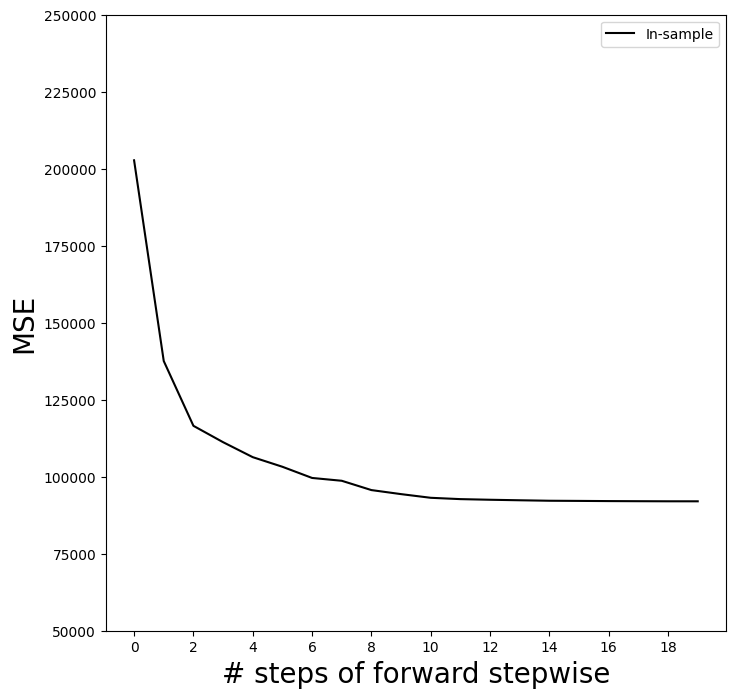

In [61]:
mse_fig, ax = subplots(figsize=(8,8))
# insample_MSE is the mean of the error to the real value in each step.
insample_mse = ((Yhat_in - Y[:,None])**2).mean(axis=0) # the comparison of the prediction to the real value
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);


Notice the expression `None` in `Y[:,None]` above.
This adds an axis (dimension) to the one-dimensional array `Y`,
which allows it to be recycled when subtracted from the two-dimensional `Yhat_in`.

We are now ready to use cross-validation to estimate test error along
the model path. We must use *only the training observations* to perform all aspects of model-fitting --- including
variable selection.  Therefore, the determination of which model of a
given size is best must be made using \emph{only the training
  observations} in each training fold. This point is subtle but important.  If the full data
set is used to select the best subset at each step, then the validation
set errors and cross-validation errors that we obtain will not be
accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold cross-validation.

In [64]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, # instead of a method as created before in pseudocode, this is a sklearn-compatible object.
                                Hitters,
                                Y,
                                cv=kfold)  #instead of a number, an entire K-fold object.
Yhat_cv.shape


(263, 20)

`skm.cross_val_predict()`
The prediction matrix `Yhat_cv` is the same shape as `Yhat_in`; **the difference is that the predictions in each row, corresponding to a particular sample index, were made from models fit on a training fold that did not include that row**.

At each model along the path, we compute the MSE in each of the cross-validation folds.
These we will average to get the  mean MSE, and can also use the individual values to compute a crude estimate of the standard error of the mean. {The estimate is crude because the five error estimates  are based on overlapping training sets, and hence are not independent.}
Hence we must know the test indices for each cross-validation
split. This can be found by using the `split()` method of `kfold`. Because
we  fixed the random state above, whenever we split any array with the same
number of rows as $Y$ we recover the same training and test indices, though we simply
ignore the training indices below.

In [65]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape


(20, 5)

We now add the cross-validation error estimates to our MSE plot.
We include the mean error across the five folds, and the estimate of the standard error of the mean. 

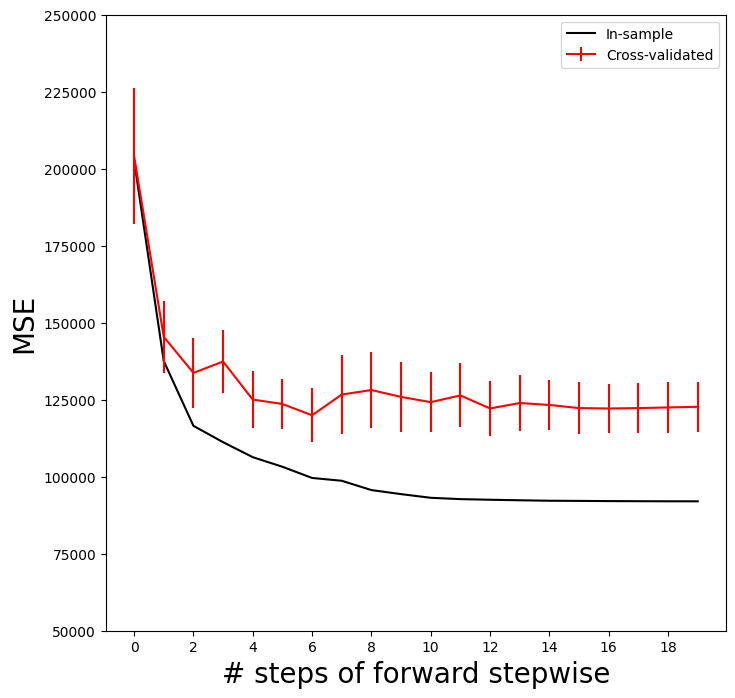

In [16]:
ax.errorbar(np.arange(n_steps), 
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig


To repeat the above using the validation set approach, we simply change our
`cv` argument to a validation set: one random split of the data into a test and training. We choose a test size
of 20%, similar to the size of each test set in 5-fold cross-validation.`skm.ShuffleSplit()`

In [66]:
validation = skm.ShuffleSplit(n_splits=1, 
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx]) # and not cross_val_predict
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)


 As for the in-sample MSE case, the validation set approach does not provide standard errors.

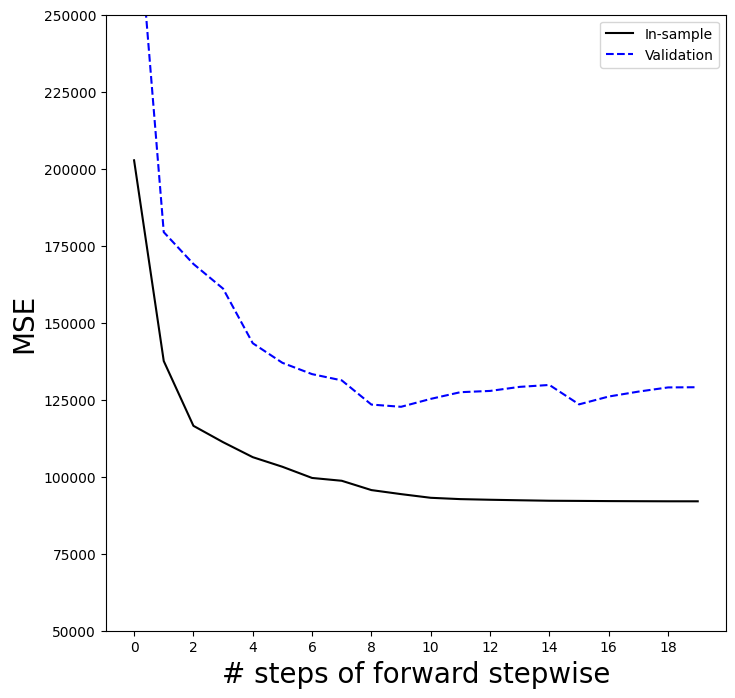

In [67]:
ax.plot(np.arange(n_steps), 
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig


### Best Subset Selection
Forward stepwise is a *greedy* selection procedure; at each step it augments the current set by including one additional variable.  We now apply best subset selection  to the  `Hitters` 
data, which for every subset size, searches for the best set of predictors.  

We will use a package called `l0bnb` to perform
best subset selection.
Instead of constraining the subset to be a given size,
this package produces a path of solutions using the subset size as a
penalty rather than a constraint. Although the distinction is subtle, the difference comes when we cross-validate. 


In [68]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)


Here we excluded the first column corresponding to the intercept, as
`l0bnb` will fit the intercept separately. We can find a path using the `fit_path()` function.

In [69]:
path = fit_path(X, 
                Y,
                max_nonzeros=X.shape[1])


Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


The function `fit_path()` returns a list whose values include the fitted coefficients as `B`, an intercept as `B0`, as well as a few other attributes related to the particular path algorithm used. Such details are beyond the scope of this book.

In [70]:
path[3]


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

In the example above, we see that at the fourth step in the path, we have two nonzero coefficients in `'B'`, corresponding to the value $0.114$ for the penalty parameter `lambda_0`.
We could make predictions using this sequence of fits on a validation set as a function of `lambda_0`, or with more work using cross-validation.

## Ridge Regression and the Lasso
We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below)
to fit ridge and  lasso regularized linear models on the `Hitters` data.
We start with the model matrix `X` (without an intercept) that we computed in the previous section on best subset regression.

### Ridge Regression

It aims to minimize not RSS but $RSS + \lambda \sum_{j=1}^{p} \beta_j^2$, with $\lambda$ a tuning parameter, which is to be selected using cross-validation. As the RSS depends entirely on the $\beta$ values, and those values depend on the values of the predictors, **it's important to normalize the coefficients before applying a Ridge regression.** The formula to standarize the predictor values is

$$
\tilde{x}_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n} \sum_{i=1}^n (x_{ij}-\bar{x}_j)}}
$$

There is a bias-variance tradeoff to take into account:
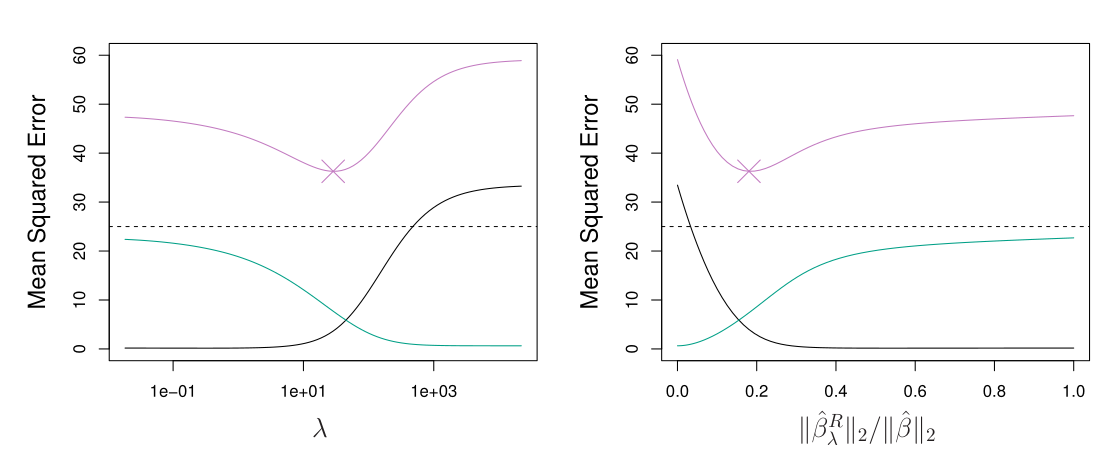

The higher $\lambda$ is, the more importance will be put on the extra term, the sum of the squared values of the different $\beta$ of the regression. Therefore, as we will try to minize the whole expression, and that sum will have a lot of importance, the variance -in green- will decrease (no matter the samples we use, the result will always the the same, $\beta_i = 0$), the bias will increase (for the same reason) and the mean squared error will plateu for high values of $\lambda$ and reach a minimum at some point, because the result will be a bit more insensitive to training noise: the regression reduces overfitting.

Why Minimum MSE ≠ Minimum λ?
```mermaid
flowchart LR
    A[λ=0] -->|Perfect fit to training data| B[Overfitting]
    B --> C[High test MSE]
    D[Moderate λ] -->|Balanced fit| E[Optimal test MSE]
    F[Large λ] -->|Over-simplified| G[High test MSE]
```

We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso.
To fit a *path* of ridge regressions models, we use `skl.ElasticNet.path()`, which can fit both Ridge and Lasso, as well as a hybrid mixture;  ridge regression
corresponds to `l1_ratio=0` (as `l2_ratio=1`, due to the fact that Ridge Regession is an $L2$ regularization, and Lasso is a $L1$ regularization).

It is good practice to standardize the columns of `X` in these applications, if the variables are measured in different units. Since `skl.ElasticNet()` does no normalization, we have to take care of that ourselves.
Since we standardize first, in order to find coefficient estimates on the original scale, we must *unstandardize* the coefficient estimates.

The parameter $\lambda$ in (6.5) and (6.7) is called `alphas` in `sklearn`. In order to be consistent with the rest of this chapter, we use `lambdas` rather than `alphas` in what follows.  {At the time of publication, ridge fits like the one in code chunk [22] issue unwarranted convergence warning messages; we expect these to disappear as this package matures.}

shape : (19, 100)
[[ 8.00310363e-04  1.00986867e-03  1.27429625e-03  1.60795803e-03
   2.02897873e-03  2.56022635e-03  3.23055259e-03  4.07635705e-03
   5.14355953e-03  6.49008625e-03  8.18900318e-03  1.03324635e-02
   1.30366790e-02  1.64481765e-02  2.07516685e-02  2.61799436e-02
   3.30262829e-02  4.16600263e-02  5.25460540e-02  6.62691128e-02
   8.35641086e-02  1.05353690e-01  1.32794665e-01  1.67334975e-01
   2.10783099e-01  2.65391712e-01  3.33957167e-01  4.19935600e-01
   5.27574963e-01  6.62059591e-01  8.29659515e-01  1.03786989e+00
   1.29551594e+00  1.61278528e+00  2.00113248e+00  2.47298231e+00
   3.04114276e+00  3.71783502e+00  4.51326873e+00  5.43375045e+00
   6.47942241e+00  7.64187866e+00  8.90206015e+00  1.02289206e+01
   1.15793023e+01  1.28992222e+01  1.41263881e+01  1.51933639e+01
   1.60305525e+01  1.65681564e+01  1.67365097e+01  1.64645520e+01
   1.56766223e+01  1.42881075e+01  1.22007644e+01  9.29874085e+00
   5.44645610e+00  4.89549723e-01 -5.73995937e+00 -1.34134

Text(0.5, 0, '$\\lambda$')

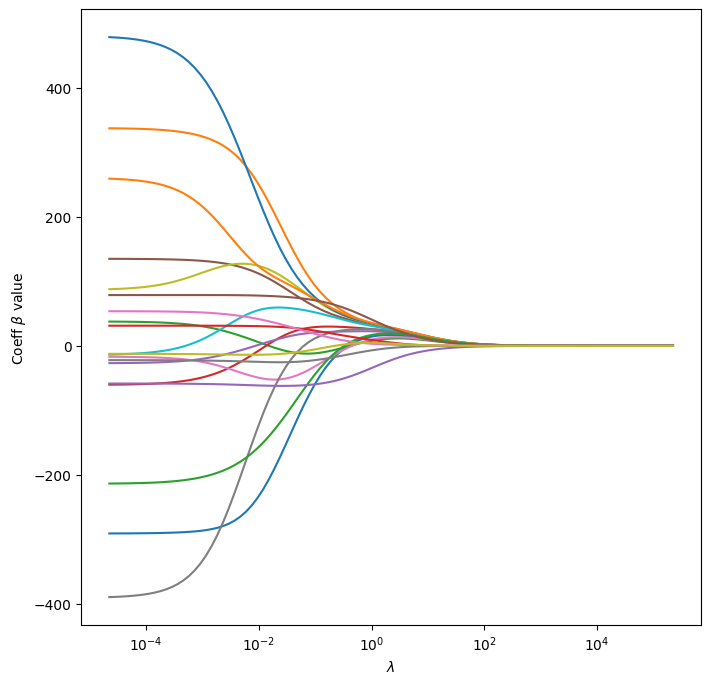

In [102]:
Xs = X - X.mean(0)[None,:] # We take away the mean from every sample
X_scale = X.std(0)         # And now we obtain the std value, which will be the value we use to normalize Xs.
Xs = Xs / X_scale[None,:]  # Standarize!
lambdas = 10**np.linspace(8, -2, 100) / Y.std() # Log-spaced values! - The lambdas are also normalized. Why?.
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    soln_array = skl.ElasticNet.path(Xs,                # the inputs, scaled
                                     Y,                 # Original target (not standardized)
                                     l1_ratio=0.,       # An L2 regularization, Ridge!
                                     alphas=lambdas)[1] # The lambdas are indeed standarized. We take only the coefficient paths. [0] is the intercept. 
print('shape :',soln_array.shape) # (n_coeffs, 100)
print(soln_array[:1])

# For each coefficient (row), we have the values of the coefficients obtained by applying ridge regression for each lambda value (a total of 100 values).
mse_fig, ax = subplots(figsize=(8,8))
# insample_MSE is the mean of the error to the real value in each step.

for i in range(soln_array.shape[0]):
    ax.semilogx(lambdas, soln_array[i])

ax.set_ylabel('Coeff $\\beta$ value')
ax.set_xlabel('$\lambda$')

In [83]:
# Another way to implement Ridge regression with moden scikit learn, without using the old ElasticNet way.
from sklearn.linear_model import Ridge # Ridge is now a linear model!

# Standardize X
Xs = (X - X.mean(0)) / X.std(0)

# Fit ridge path
alphas = 10**np.linspace(8, -2, 100) # alphas are distributed logarithmically
coefs = []
for a in alphas: #for each possible alpha value we want to test
    ridge = Ridge(alpha=a, fit_intercept=True) # we create a ridge regression using that alpha value
    ridge.fit(Xs, Y) # we fit it. we do not predict, careful here!
    coefs.append(ridge.coef_) # and as we got the coefficients, we just list them
    
coefs = np.array(coefs).T  # Same shape as soln_array
print('shape ',coefs.shape) # (n_coeffs, 100)
print(coefs[:1])

shape  (19, 100)
[[ 4.67472846e-04  5.89880940e-04  7.44340724e-04  9.39244141e-04
   1.18518002e-03  1.49550900e-03  1.88708876e-03  2.38118886e-03
   3.00464459e-03  3.79131211e-03  4.78390326e-03  6.03629871e-03
   7.61646340e-03  9.61011989e-03  1.21253751e-02  1.52985445e-02
   1.93014799e-02  2.43507808e-02  3.07193628e-02  3.87509667e-02
   4.88783282e-02  6.16458826e-02  7.77380660e-02  9.80144701e-02
   1.23553327e-01  1.55705001e-01  1.96157310e-01  2.47014554e-01
   3.10891937e-01  3.91026469e-01  4.91404243e-01  6.16901688e-01
   7.73434592e-01  9.68102712e-01  1.20930886e+00  1.50681890e+00
   1.87171322e+00  2.31616162e+00  2.85293698e+00  3.49457396e+00
   4.25209099e+00  5.13323995e+00  6.14034130e+00  7.26790203e+00
   8.50037315e+00  9.81052214e+00  1.11588952e+01  1.24946635e+01
   1.37578008e+01  1.48821283e+01  1.57984494e+01  1.64369086e+01
   1.67278756e+01  1.66009973e+01  1.59824739e+01  1.47909882e+01
   1.29330275e+01  1.02985673e+01  6.75824280e+00  2.163212

Here we extract the array of coefficients corresponding to the solutions along the regularization path.
By default the `skl.ElasticNet.path` method fits a path along
an automatically selected range of $\lambda$ values, except for the case when
`l1_ratio=0`, which results in ridge regression (as is the case here). {The reason is rather technical; for all models except ridge, we can find the smallest value of $\lambda$ for which all coefficients are zero. For ridge this value is $\infty$.}  So here
we have chosen to implement the function over a grid of values ranging
from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard
deviation of $y$, essentially covering the full range of scenarios
from the null model containing only the intercept, to the least
squares fit.

Associated with each value of $\lambda$ is a vector of ridge
regression coefficients,   that can be accessed by
a column of `soln_array`. In this case, `soln_array` is a $19 \times 100$ matrix, with
19 rows (one for each predictor) and 100
columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [98]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


We plot the paths to get a sense of how the coefficients vary with $\lambda$.
To control the location of the legend we first set `legend` to `False` in the
plot method, adding it afterward with the `legend()` method of `ax`.

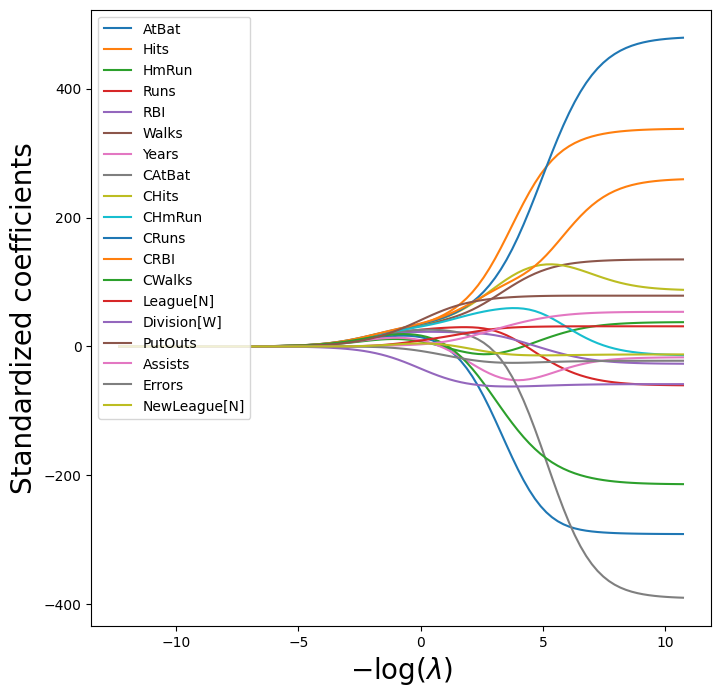

In [99]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');


We expect the coefficient estimates to be much smaller, in terms of
$\ell_2$ norm, when a large value of $\lambda$ is used, as compared to
when a small value of $\lambda$ is used. (Recall that the  $\ell_2$ norm is the square root of the sum of squared coefficient values.) We display  the coefficients at the $40$th step,
where $\lambda$ is 25.535.

In [104]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat


(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

Let’s compute the $\ell_2$ norm of the standardized coefficients.

In [105]:
np.linalg.norm(beta_hat)


24.17061720144378

In contrast, here is the $\ell_2$ norm when $\lambda$ is 2.44e-01.
Note the much larger $\ell_2$ norm of the
coefficients associated with this smaller value of $\lambda$.

In [106]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)


(0.24374766133488554, 160.42371017725912)

Above we normalized `X` upfront, and fit the ridge model using `Xs`.
The `Pipeline()`  object
in `sklearn` provides a clear way to separate feature
normalization from the fitting of the ridge model itself.

In [125]:
ridge = Ridge(alpha=lambdas[59], fit_intercept=True)# this uses a certain alpha. So this does not pick the best alpha yet!
#ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0) 
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.24374766133488554))])

We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [126]:
np.linalg.norm(ridge.coef_)


785.3470550725027

In [127]:
ridge.coef_

array([-286.92800356,  325.5927237 ,   30.73839158,  -49.64545842,
        -20.46163007,  131.99882072,  -24.4600964 , -337.10209091,
        112.51349113,    8.91923939,  420.47285157,  218.46314157,
       -204.04558648,   31.26452821,  -59.03756974,   78.76932348,
         51.9010374 ,  -22.74707929,  -12.96266649])

 Notice that the operation `pipe.fit(X, Y)` above has changed the `ridge` object, and in particular has added attributes such as `coef_` that were not there before. 
### Estimating Test Error of Ridge Regression
Choosing an *a priori* value of $\lambda$ for ridge regression is
difficult if not impossible. We will want to use the validation method
or cross-validation to select the tuning parameter. The reader may not
be surprised that the  `Pipeline()` approach can be used in
`skm.cross_validate()` with either a validation method
(i.e. `validation`) or $k$-fold cross-validation.

We fix the random state of the splitter
so that the results obtained will be reproducible.

What does this do?

In [128]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,  # 50% testing, 50% training.
                              random_state=0) # we use a validation and not a cross-validation approach for now. 1 random train-test split!

ridge.alpha = 0.01 # this sets an alpha on the regression. It has been fit before, does it have to be fit before doing this? No, because lambda will change.
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation) #it will performce the validation split from before, 50/50. Train on the 50%, test on the remaining 50%. SINGLE.
-results['test_score']

# Then it will:
# shuffle split 50/50
# take the training set and fit the model.
# then predict on that model the values for the test set
# then it will calculate the MSE (negative)
# and output the result of the MSE, negated.

# Therefore, it's only ONE validation it will perform.
# This will be executed ONLY once. One single fit. One single prediction.
# This is exactly like using train_test_split, but inside cross_validate.

array([134596.76230062])

The test MSE is 1.342e+05.  Note
that if we had instead simply fit a model with just an intercept, we
would have predicted each test observation using the mean of the
training observations. We can get the same result by fitting a ridge regression model
with a *very* large value of $\lambda$. Note that `1e10`
means $10^{10}$.

In [129]:
ridge.alpha = 1e10 # let's calculate something very similar to the mean of all samples!
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


array([224042.3789389])

Obviously choosing $\lambda=0.01$ is arbitrary,  so we will  use cross-validation or the validation-set
approach to choose the tuning parameter $\lambda$.
The object `GridSearchCV()`  allows exhaustive
grid search to choose such a parameter.

We first use the validation set method
to choose $\lambda$.

In [130]:
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

param_grid = {'ridge__alpha': lambdas} # this is the parameter we are going to tune! The lambdas are a logspace!

with warnings.catch_warnings(): # supress warnings
    warnings.simplefilter("ignore")
    
    grid = skm.GridSearchCV(pipe,           # this is the pipeline to optimize: scaler+ridge
                            param_grid,     # and we are going to use the param_grid dictionary
                            cv=validation,  # and we are going to use a validation approach: in this case, a standard split.
                            scoring='neg_mean_squared_error')  # and in all cases we are going to measure how good we did on each alpha with this core.
    
    grid.fit(X, Y)        # Fitting the gridsearch will end up making the best parameter emerge. 
    # 1. divide the samples into 50% train, 50% test.
    # 2. For each lambda,
        # scale it, --> separately for each train/validation split! so no data leakage! This is important!
        # fit a train regression
        # calculate the MSE on the validation set,
        # and get a score.
    # 3. compare all alphas and decide which one is the best.
    
    grid.best_params_['ridge__alpha'] # best lambda
    grid.best_estimator_ # best pipeline!

In [131]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.7798138828236654))])

Alternatively, we can use 5-fold cross-validation.

In [132]:
grid = skm.GridSearchCV(pipe,  # The same pipe
                        param_grid, # the same grid
                        cv=kfold, #but a k-fold cv
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)  # find the best one as the mean of several folds having been tested on each step
grid.best_params_['ridge__alpha']
grid.best_estimator_


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=2.494832928915928))])

Recall we set up the `kfold` object for 5-fold cross-validation on page 298. We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left
to right.

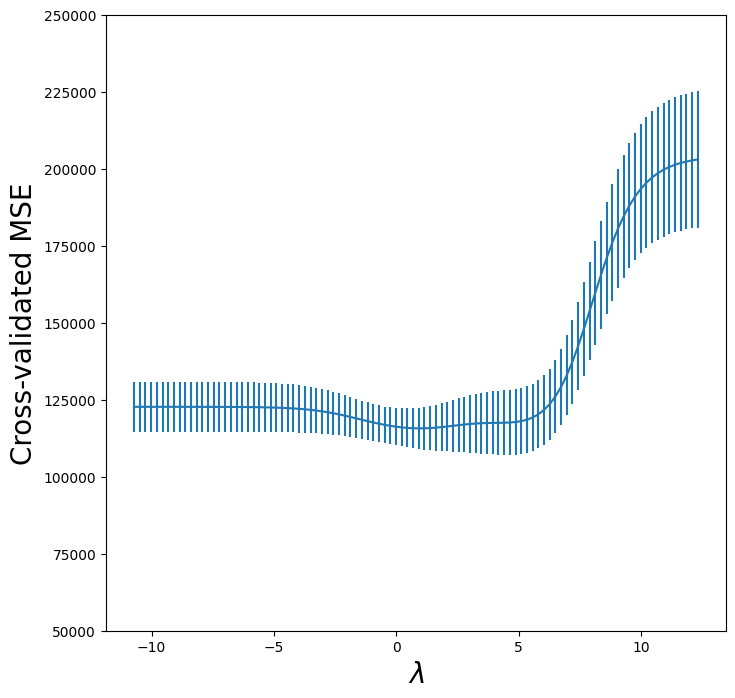

In [137]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(np.log(lambdas),
            -grid.cv_results_['mean_test_score'], # negative because of the negative of the score was calculated.
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel('$\lambda$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


One can cross-validate different metrics to choose a parameter. The default
metric for `skl.ElasticNet()` is test $R^2$.
Let’s compare $R^2$ to MSE for cross-validation here.

In [141]:
grid_r2 = skm.GridSearchCV(pipe, 
                           param_grid,
                           cv=kfold,
                           scoring='r2')
grid_r2.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge(alpha=10000000000.0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])},
             scoring='r2')

Finally, let’s plot the results for cross-validated $R^2$.

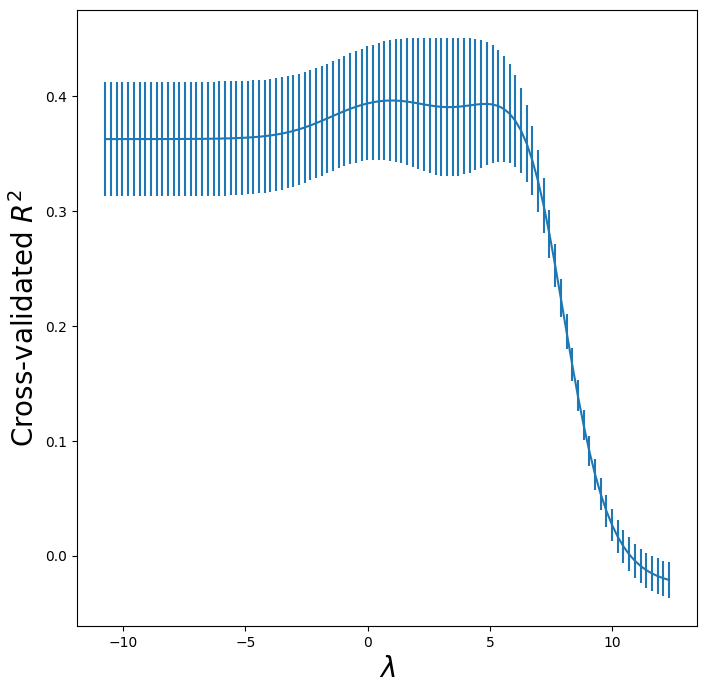

In [140]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$\lambda$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


### Fast Cross-Validation for Solution Paths
The **ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a *solution path* or *regularization path***. Hence there is specialized code to fit
such paths, and to choose a suitable value of $\lambda$ using cross-validation. Even with
identical splits the results will not agree *exactly* with our `grid`
above because the standardization of each feature  in `grid` is carried out on each fold,
while in `pipeCV` below it is carried out only once.
Nevertheless, the results are similar as the normalization
is relatively stable across folds.

In [154]:
#ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
#                           l1_ratio=0,
#                           cv=kfold)
#pipeCV = Pipeline(steps=[('scaler', scaler),
#                         ('ridge', ridgeCV)])
#pipeCV.fit(X, Y)

# A modern approach

from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Instead of using GridSearch, sklearn has its own Ridge regression cross-validated model, which automatically finds the best lambda using cross validation
# It's also faster in finding the best lambda because it's not using gradient descent but Cholesky decomposition.
# and refits the model using the best lambda.

# Create pipeline with built-in CV
pipeCV = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=lambdas,  # Array of alpha values to try
        cv=kfold,        # Your cross-validator
        scoring='neg_mean_squared_error'  # Default
    )
)

# Fit once - automatically finds best alpha
pipeCV.fit(X, Y)

# Access results
best_alpha = pipeCV.named_steps['ridgecv'].alpha_
best_coefs = pipeCV.named_steps['ridgecv'].coef_

Let’s produce a plot again of the cross-validation error to see that
it is similar to using `skm.GridSearchCV`.

In [156]:
#tuned_ridge = pipeCV.named_steps['ridgecv']
#ridgeCV_fig, ax = subplots(figsize=(8,8))
#ax.errorbar(-np.log(lambdas),
#            tuned_ridge.mse_path_.mean(1),
#            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
#ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
#ax.set_ylim([50000,250000])
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
#ax.set_ylabel('Cross-validated MSE', fontsize=20);


In [157]:
tuned_ridge.set_score_request

<function sklearn.utils._metadata_requests.RequestMethod.__get__.<locals>.func(self: sklearn.linear_model._ridge.RidgeCV, *, sample_weight: Union[bool, NoneType, str] = '$UNCHANGED$') -> sklearn.linear_model._ridge.RidgeCV>

We see that the value of $\lambda$ that results in the
smallest cross-validation error is 1.19e-02, available
as the value `tuned_ridge.alpha_`. What is the test MSE
associated with this value of $\lambda$?

In [159]:
# np.min(tuned_ridge.mse_path_.mean(1))


This represents a further improvement over the test MSE that we got
using $\lambda=4$.  Finally, `tuned_ridge.coef_`
has the coefficients fit on the entire data set
at this value of  $\lambda$.

In [160]:
tuned_ridge.coef_


array([-235.72497905,  253.05642833,    6.24782371,   -8.44450763,
          1.04320683,  112.84181561,  -49.11587947, -127.34656694,
        124.49712479,   55.04269704,  231.62603982,  124.6086533 ,
       -158.60546327,   30.55498489,  -61.37429494,   78.0012172 ,
         41.81539953,  -24.78446896,  -13.80530157])

As expected, **none of the coefficients are zero—ridge regression does
not perform variable selection!**

### Evaluating Test Error of Cross-Validated Ridge
Choosing $\lambda$ using cross-validation provides a single regression
estimator, similar to fitting a linear regression model as we saw in
Chapter 3. It is therefore reasonable to estimate what its test error
is. We run into a problem here in that cross-validation will have
*touched* all of its data in choosing $\lambda$, hence we have no
further data to estimate test error. A compromise is to do an initial
split of the data into two disjoint sets: a training set and a test set.
We then fit a cross-validation
tuned ridge regression on the training set, and evaluate its performance on the test set.
We might call this cross-validation nested
within the validation set approach.

```mermaid
flowchart TD
    FullData --> Train --> CV_Folds
    FullData --> Test
```

```mermaid
flowchart TD
    A[Full Dataset] --> B[Initial Split]
    B --> C[Training Set]
    B --> D[Test Set -Holdout]
    
    subgraph "Nested CV on Training Set"
        C --> E[Fold 1: Train # Val]
        C --> F[Fold 2: Train # Val]
        C --> G[...]
        C --> H[Fold K: Train # Val]
    end
    
    E --> I[Select Best λ]
    F --> I
    H --> I
    
    I --> J[Final Model: Retrain on Full Training Set with Best λ]
    J --> K[Evaluate on Test Set]
```

A priori there is no reason to use
half of the data for each of the two sets in validation. Below, we use
75% for training and 25% for test, with the estimator being ridge
regression tuned using 5-fold cross-validation.  This can be achieved
in code as follows:

In [163]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,    # test size: 25%
                               random_state=1)

inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)

#ridgeCV = skl.ElasticNetCV(alphas=lambdas,
#                           l1_ratio=0,
#                           cv=inner_cv)

ridgeCV = skl.RidgeCV(alphas=lambdas, cv=inner_cv)

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);


In [164]:
results = skm.cross_validate(pipeCV, # Scaler + RidgeCV (this CV is performed on the inside) 
                             X,
                             Y,
                             cv=outer_valid, # outer validation with the first test_set
                             scoring='neg_mean_squared_error')
-results['test_score']


array([132744.64471659])

### The Lasso: Another way of variable selection
We saw that ridge regression with a wise choice of $\lambda$ can
outperform least squares as well as the null model on the
 `Hitters`  data set. We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression.

Ridge regression will include all predictors in the final model. Lasso will eliminate some predictors, so it's a form of variable selection, and produces sparse models.

As with Ridge, Lasso, which is an $L_1$ penalty, aims to minimize not RSS but $RSS + \lambda \sum_{j=1}^{p} \left|\beta_j\right|$, with $\lambda$ a tuning parameter, which is to be selected using cross-validation. As the RSS depends entirely on the $\beta$ values, and those values depend on the values of the predictors, **it's important to normalize the coefficients before applying a Ridge regression.** The formula to standarize the predictor values is, as with Ridge,

$$
\tilde{x}_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n} \sum_{i=1}^n (x_{ij}-\bar{x}_j)}}
$$

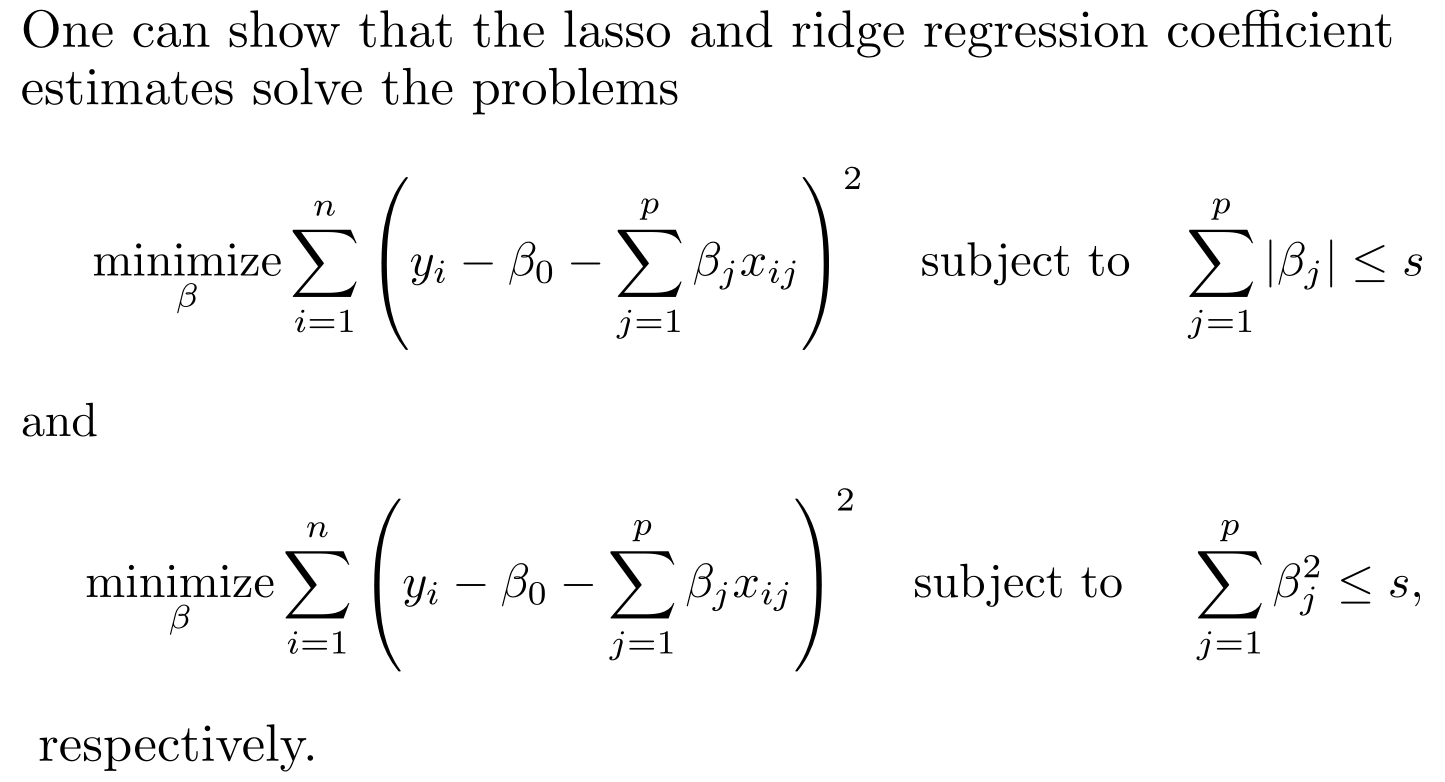
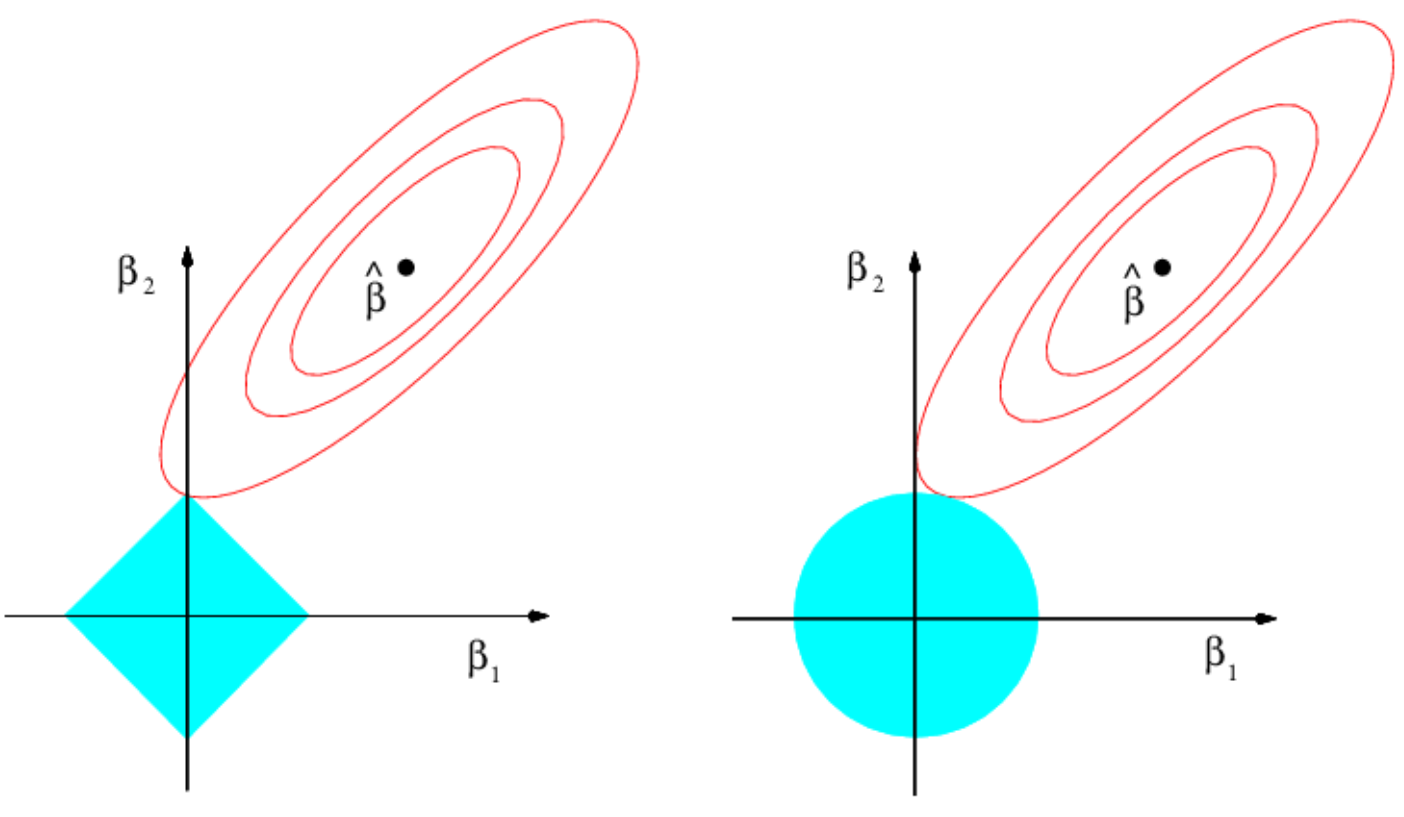

In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [165]:
lassoCV = skl.ElasticNetCV(n_alphas=100, # number of lambdas to try. We could also give it the lambdas themselves. 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


2.737306244504529

In [166]:
# Just as before, we have the modern alternative, LassoCV

from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

# 1. Create pipeline with built-in CV (cleaner syntax)
pipeCV = make_pipeline(
    StandardScaler(),
    LassoCV(
        n_alphas=100,       # Number of alpha values to try
        cv=kfold,           # Your cross-validator
        random_state=42,
        selection='cyclic'  # Modern default
    )
)

# 2. Fit once - automatically finds best alpha
pipeCV.fit(X, Y)

# 3. Access results (modern attribute names)
tuned_lasso = pipeCV.named_steps['lassocv']
print(f"Best alpha: {tuned_lasso.alpha_:.4f}")
print(f"Number of non-zero coefficients: {(tuned_lasso.coef_ != 0).sum()}")

Best alpha: 2.7373
Number of non-zero coefficients: 13


In [169]:
#lambdas, soln_array = skl.Lasso.path(Xs, # scaled
#                                    Y,
#                                    l1_ratio=1,
#                                    n_alphas=100)[:2]
from sklearn.linear_model import lasso_path  # Dedicated function
# 2. Compute Lasso path (modern approach)
alphas, coefs, _ = lasso_path(
    Xs, 
    Y,
    n_alphas=100,      # Number of lambda values
    eps=1e-3,          # Ratio min_alpha/max_alpha (default 1e-3)
)

soln_path = pd.DataFrame(soln_array.T,            # Transpose to (n_alphas, n_features)
                         columns=D.columns,
                         index=-np.log(lambdas)) # Convert alphas to -log(λ) scale


We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

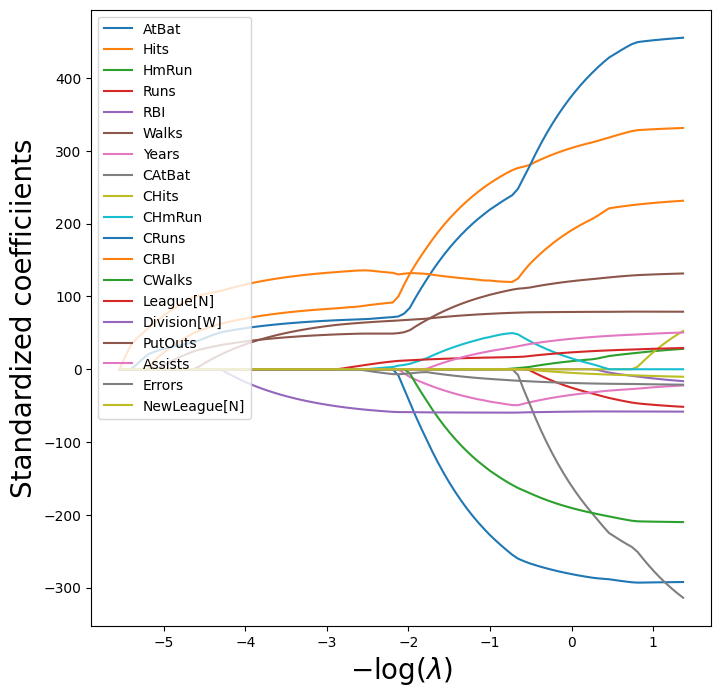

In [170]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression (page 305) with $\lambda$ chosen by cross-validation.

In [171]:
np.min(tuned_lasso.mse_path_.mean(1))


119388.19828719688

Let’s again produce a plot of the cross-validation error.


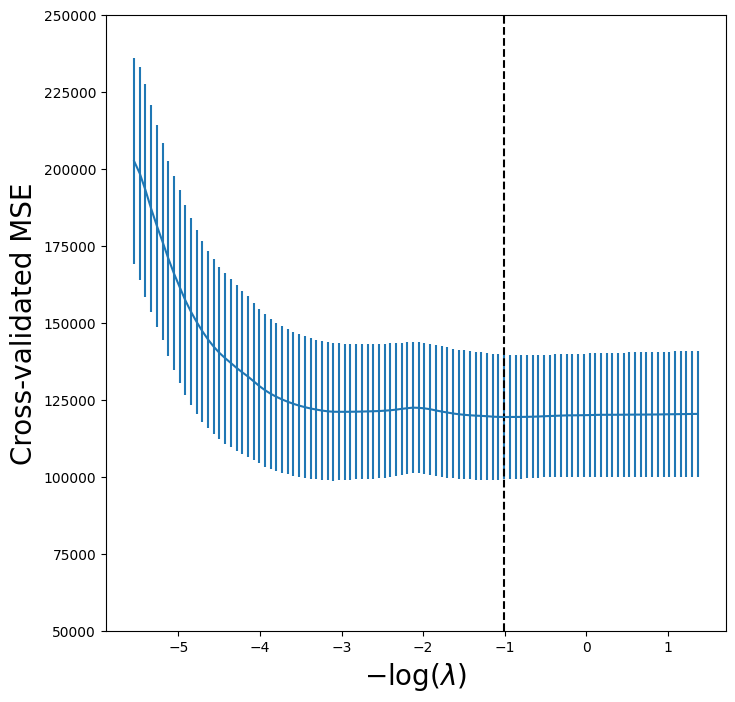

In [172]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

However, the lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are sparse. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

In [173]:
tuned_lasso.coef_


array([-226.83004696,  254.82706494,    0.        ,   -0.        ,
          0.        ,  102.14493902,  -44.59414305,   -0.        ,
          0.        ,   43.36295623,  218.02899432,  123.42086296,
       -138.61718612,   16.04104388,  -59.54521107,   76.10379606,
         24.74415012,  -13.25252655,   -0.        ])

As in ridge regression, we could evaluate the test error
of cross-validated lasso by first splitting into
test and training sets and internally running
cross-validation on the training set. We leave
this as an exercise.

## PCR and PLS Regression: Dimension reduction methods

These methods transform the preditors into another thing, another set of variables $Z_n$, effectively reducing the dimensions for the transformed variables.

Starting from $X_1,..,X_p$, we can define $Z_1, ..., Z_M$, $M<p$, linear combinations of the original $p$ predictors. This way,
$$
Z_m = \sum_{j=1}^p \phi_{mj}X_j \qquad  \text{for constants } \phi_{m1}, ..., $\phi_{mp}
$$

So we now fit the linear regression model not on the original parameters but on the new ones, that are just a linear combination of the original ones.

$$
y_i = \theta_0 + \sum_{m=1}^{M} \theta_m z_{im} + \epsilon_i, i=1,...,n
$$

but
$$
\sum_{m=1}^{M} \theta_{mj} z_{im} = \sum_{m=1}^{M} \theta_{mj} \sum_{j=1}^p \phi_{mj}x_{ij} = \sum_{m=1}^{M} \sum_{j=1}^p \theta_{mj} \phi_{mj}x_{ij}
$$
And we then can define that
$$
\sum_{m=1}^{M}  \theta_{m} \phi_{m} =  \beta_j
$$
And therefore
$$
\sum_{m=1}^{M} \theta_{mj} z_{im} =  \sum_{j=1}^p \beta_{j} x_{ij}
$$

Which means that we are on a new, different way of contraint on the legal $\beta$ values we may end up with, similar to the Lasso and Ridge case, but slightly more complex.


### Principal Components Regression

It's unsupervised: We don't use the response (Y) to determine the principal component directions. --> **No podemos estar seguros de que las mejores combinaciones lineales entre predictores sean las que más impactan en la respuesta.**

- First principal component: The **combination of variables** with the larger variance.
- Second principal component: The **combination of variables** with the larger variance, subject to being uncorrelated to the first.

Principal components regression (PCR) can be performed using
`PCA()`  from the `sklearn.decomposition`
module. We now apply PCR to the  `Hitters`  data, in order to
predict `Salary`. Again, ensure that the missing values have
been removed from the data, as described in Section 6.5.1.

We use `LinearRegression()`  to fit the regression model
here. Note that it fits an intercept by default, unlike
the `OLS()` function seen earlier in Section 6.5.1.

In [174]:
pca = PCA(n_components=2) # we have to define how many dimensions we want to consider

linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), # we will first create the new variables, pick one combination after the other based on the largest variance,
                 ('linreg', linreg)]) # then apply the linear regression on the transformed variables

pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_


array([0.09846131, 0.4758765 ])

When performing PCA, the results vary depending
on whether the data has been *standardized* or not.
As in the earlier examples, this can be accomplished
by including an additional step in the pipeline.

In [175]:
pipe = Pipeline([('scaler', scaler),  # we must not forget to standarize!
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_


array([106.36859204,  21.60350456])

We can of course use CV to choose the number of components, by
using `skm.GridSearchCV`, in this
case fixing the parameters to vary the
`n_components`.

In [177]:
param_grid = {'pca__n_components': range(1, 20)} # the number of components is the variable we want to move
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

Let’s plot the results as we have for other methods.

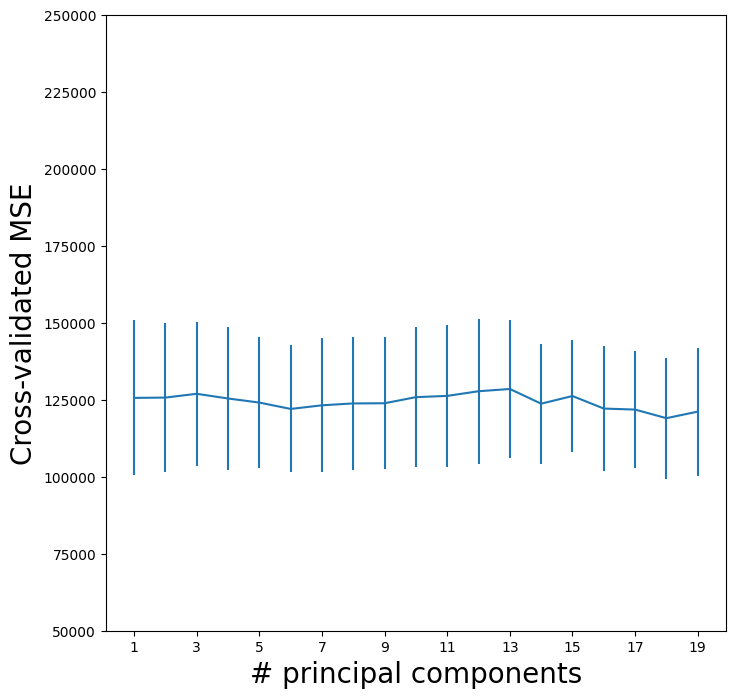

In [179]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);


We see that the smallest cross-validation error occurs when
17
components are used. However, from the plot we also see that the
cross-validation error is roughly the same when only one component is
included in the model. This suggests that a model that uses just a
small number of components might suffice.

The CV score is provided for each possible number of components from
1 to 19 inclusive. The `PCA()` method complains
if we try to fit an intercept only with `n_components=0`
so we also compute the MSE for just the null model with
these splits.

In [180]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()


205647.1703998647

The `explained_variance_ratio_`
attribute of our `PCA` object provides the *percentage of variance explained* in the predictors and in the response using
different numbers of components. This concept is discussed in greater
detail in Section 12.2.

In [181]:
pipe.named_steps['pca'].explained_variance_ratio_


array([0.3831424 , 0.21841076])

Briefly, we can think of
this as the amount of information about the predictors
that is captured using $M$ principal components. For example, setting
$M=1$ only captures 38.31% of the variance, while $M=2$ captures an additional 21.84%, for a total of 60.15% of the variance.
By  $M=6$ it increases to
88.63%. Beyond this the increments continue to diminish, until we use all $M=p=19$ components, which captures all  100% of the variance.

 

### Partial Least Squares


- Like PCR, PLS is a dimension reduction method, which
first identifies a new set of features $Z_1 , . . . , Z_M$ that are
linear combinations of the original features, and then fits a
linear model via OLS using these $M$ new features.
- But unlike PCR, **PLS identifies these new features in a
supervised way – that is, it makes use of the response Y in
order to identify new features that not only approximate
the old features well, but also that are related to the
response**.
- Roughly speaking, the PLS approach attempts to find
**directions that help explain both the response and the
predictors**.


It computes the first direction $Z_1$ by setting each $\phi_{1j}$ equal to the coefficient from the linear regression of $Y$ into $X_j$, that is, the coefficient is proportional to the correlation between the preditor $X_j$ and the response $Y$. This is how the response is used!

In computing $Z_1 = \sum_{j=1}^p \phi_{1j} X_j$ , PLS places the
highest weight on the variables that are most strongly
related to the response. Subsequent directions are found by taking residuals and
then repeating the above prescription.

Partial least squares (PLS) is implemented in the
`PLSRegression()`  function.

 

In [182]:
pls = PLSRegression(n_components=2, # Again the number of componets to use, just like in the case of PCA.
                    scale=True)
pls.fit(X, Y)


PLSRegression()

As was the case in PCR, we will want to
use CV to choose the number of components.

In [183]:
param_grid = {'n_components':range(1, 20)} # and we will want to change the number of componrnts of this regression by using gridsearch.
grid = skm.GridSearchCV(pls, # the PLS regression
                        param_grid, # considering between 1 and 19 components
                        cv=kfold, # and using the old k-fold CV
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

As for our other methods, we plot the MSE.

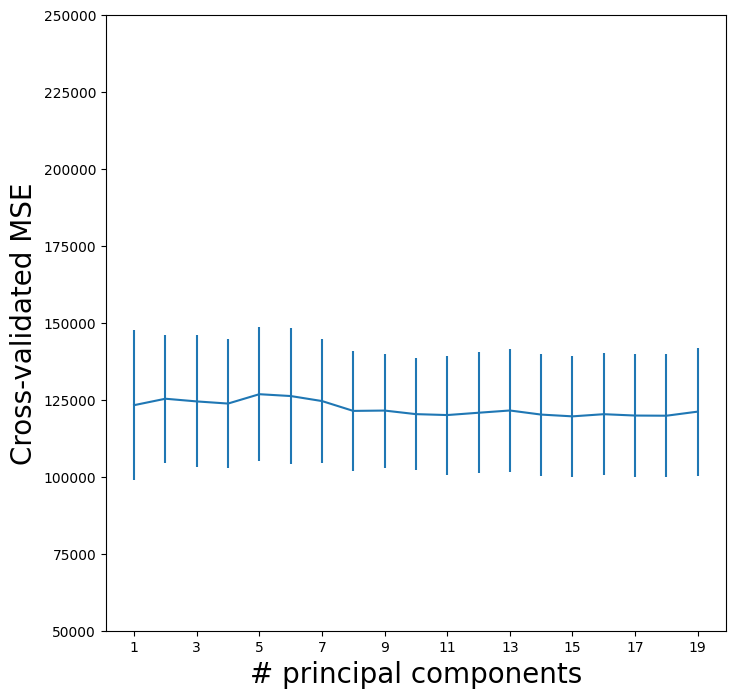

In [184]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);


CV error is minimized at 12,
though there is little noticable difference between this point and a much lower number like 2 or 3 components.

